## Logistic Regression
1. [读取数据](#读取数据)
2. [画出数据点](#画出数据点)
3. [构建模型](#构建模型)
4. [梯度下降法优化训练](#梯度下降法优化训练)
5. [使用scipy的optimize模块进行优化训练, 并动态演示迭代过程](#scipy)
5. [对比matlab的结果](#对比matlab的结果)
5. [Plot the convergence graph](#convergenceGraph)
4. [使用sklearn训练LogisticRegression模型](#使用sklearn训练LogisticRegression模型)
4. [逻辑回归损失函数的推导](#逻辑回归损失函数的推导)

In [1]:
%matplotlib inline
#%pylab
import numpy as np
import matplotlib.animation as animation 
import matplotlib.pyplot as plt
from matplotlib import style 
import theano
import theano.tensor as T
import time

/home/lsr/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using gpu device 0: GeForce GTX 750 Ti (CNMeM is disabled, CuDNN 3007)


### 读取数据

In [2]:
data  = np.loadtxt('ex2data1.txt', delimiter=',', dtype='float32')
X = data[:, [0, 1]]
Y= data[:, 2]
m = len(X)

### 画出数据点

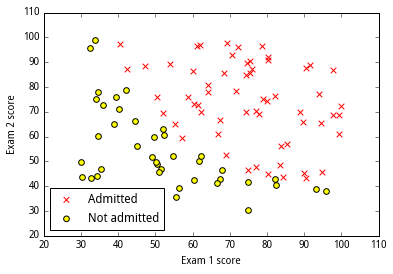

In [3]:
fig = plt.figure()
pos = plt.scatter(X[Y == 1, 0], X[Y == 1, 1], s=32, c='red', marker='x')
neg = plt.scatter(X[Y == 0, 0], X[Y == 0, 1], s=32, c='yellow', marker='o')
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.legend((pos, neg), ('Admitted', 'Not admitted'), scatterpoints=1, loc='lower left', ncol=1, fontsize=12) # 这样给scatter添加lagend

In [4]:
# 添加一列 1 在 X 上
XTemp = np.ones([m,3], dtype='float32')
XTemp[:, [1, 2]] = X
X = XTemp

#### sigmod function
$$ g(z) = \frac {1} { 1 + e ^ {-z} } $$

In [5]:
def sigmoid(z):
    return 1 / (1 + T.exp(-z))

### 构建模型
#### hypothesis
$$ h _ { \theta } (x) = g ( \theta ^ Tx ) $$
#### loss function<span id="jump"></span>
$$ J ( \theta ) = \frac {1} {m} \sum_{ i=1 } ^ {m} \left[ - y^ { (i) } \log ( h_{ \theta } ( x ^ { (i) } ) ) - (1 - y^{ (i) } ) \log ( 1 - h_{ \theta } ( x ^ { (i) } ) ) \right] $$
[逻辑回归损失函数的推导](#logisticLoss)

In [6]:
x = theano.shared(X, name='x')  # 将训练数据放入gpu (100, 3) 
y = theano.shared(Y, name='y')  # (100, )
theta = theano.shared(np.zeros([3, 1], dtype='float32'), name='theta')
alpha = T.scalar('alpha') # 学习率
pre_prob = sigmoid(x.dot(theta)) # (100, 1)
loss = T.mean(-y.dimshuffle(0, 'x') * T.log(pre_prob) - (1- y.dimshuffle(0, 'x')) * T.log(1 - pre_prob)) # y需要是vector,需要dimshuffle
calcLoss = theano.function([], loss)
precision = theano.function([], T.eq(T.ge(pre_prob, 0.5), y.dimshuffle(0, 'x')).sum() / T.cast(x.shape[0], 'float32')) # 计算分类准确率

#### gradient w.s.t theta
$$  \frac{ \partial { J ( \theta ) } } { \partial { \theta_j } } = \frac {1} {m} \sum_{ i = 1} ^ {m} \left ( h_{ \theta } (x^{ (i) } )  - y^{ (i) } \right ) x_j^{ (i) } $$
#### update theta with gradient descent
$$ \theta = \theta - \alpha \nabla \theta  $$

In [7]:
grad_all = T.mean((pre_prob - y.dimshuffle(0, 'x')).repeat(3, 1) * x, axis=0)  # 求梯度
gradient_step_all = theano.function([alpha],updates={theta : theta - alpha * grad_all.dimshuffle(0, 'x')})  # 梯度下降

In [8]:
grad_auto = T.grad(loss, theta) # 自动求梯度
gradient_step_auto = theano.function([alpha],updates={theta : theta - alpha * grad_auto})

In [9]:
print calcLoss()
print grad_all.eval({})
print grad_auto.eval({})

0.693147182465
[ -0.1        -12.00921345 -11.26284027]
CudaNdarray([[ -0.10000001]
 [-12.00921631]
 [-11.26284122]])


### 梯度下降法优化训练

In [10]:
startTime = time.time() # cpu 39.1s, gpu并没有快
# 训练,动态调整梯度
theta.set_value(np.zeros([3, 1], dtype='float32'))
max_iters = 100000
alpha = 0.1
best_loss = np.Inf
best_theta = theta.get_value()
J_history = np.zeros((max_iters, 1))
for i in range(max_iters):
    theta.set_value(best_theta)
    gradient_step_auto(alpha)
    tempLoss = calcLoss()
    J_history[i] = tempLoss
    if tempLoss < best_loss:
        best_loss = tempLoss
        best_theta = theta.get_value()
    else:
        alpha = alpha * 0.99
endTime = time.time()
print theta.get_value()
print 'training cost %.1fs' % (endTime - startTime)

[[-4.84879446]
 [ 0.04555983]
 [ 0.03848256]]
training cost 39.2s


### 使用scipy的optimize模块进行优化训练, 并动态演示迭代过程<span id='scipy'></span>

In [11]:
# 计算指定theta时的cost,使用optimize的函数时,传入的待优化参数是一个一维向量,所以要转成二维列向量,并且使用fmin时还需要转成float32类型
def computeCost(theta_value):
    theta.set_value(theta_value.reshape(3,1).astype('float32'))
    return calcLoss()

# 计算指定theta时的梯度
calcGrad= theano.function([], grad_auto)
def train_fn_grad(theta_value):
    theta.set_value(theta_value.reshape(3,1).astype('float32'))
    return np.array(calcGrad().reshape(3)) # 梯度也要转为一维向量

In [13]:
%matplotlib auto
from scipy import optimize
thetaV = [] # 存储每一次迭代后的结果
def optimizeTheta():
    # x0传入theta的一维向量形式
    result = optimize.fmin(computeCost, x0=np.zeros(3, dtype=theano.config.floatX), maxiter=1000, 
                           full_output=True, callback=lambda t : thetaV.append(t.reshape(3, 1)))     # 使用fmin求最优解,使用的是Nelder-Mead(单纯形法)
    return result[0], result[1]
thetaValue, mincost = optimizeTheta()
print thetaValue

# 动画演示迭代过程
def plotDecisionBoundaryAnimation(i): # 动态地画出决策边界
    # 先画出数据点
    fig.clear()
    pos = plt.scatter(X[Y == 1, 1], X[Y == 1, 2], s=32, c='red', marker='x')
    neg = plt.scatter(X[Y == 0, 1], X[Y == 0, 2], s=32, c='yellow', marker='o')
    plt.xlabel('Exam 1 score')
    plt.ylabel('Exam 2 score')
    plt.legend((pos, neg), ('Admitted', 'Not admitted'), scatterpoints=1, loc='lower left', ncol=1, fontsize=12) # 这样给scatter添加lagend
    # 画决策边界
    plot_x = [X[:, 1].min() - 2, X[:, 1].max() + 2]
    plot_y = -(thetaV[i][1] * plot_x + thetaV[i][0]) / thetaV[i][2]
    plt.plot(plot_x, plot_y)

# 动态演示迭代优化的过程
fig = plt.figure() 
ani = animation.FuncAnimation(fig, plotDecisionBoundaryAnimation, frames=len(thetaV), interval = 1) # 每10ms调用一次animate绘图
plt.show() 

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 146
         Function evaluations: 279
[-25.16562154   0.20625054   0.20152201]


In [14]:
# 使用minimize函数优化,只有Nelder-Mead才能求出最优解,其他都报nan
result = optimize.minimize(computeCost, np.zeros(3, dtype=theano.config.floatX),  method='Nelder-Mead', options={"maxiter":500, "disp":True} )
thetaValue, mincost = np.array([result.x]), result.fun
print thetaValue

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 146
         Function evaluations: 279
[[-25.16562154   0.20625054   0.20152201]]


In [17]:
# 使用计算得到的参数进行分类,求出分类准确率
theta.set_value(thetaValue.reshape(3, 1).astype('float32')) # 设置theta的值
precision()

array(0.8899999856948853)

In [18]:
# 使用共轭梯度法优化,报nan
thetaValue = optimize.fmin_cg(
    f=computeCost,
    x0=np.random.rand(3,1),
    fprime=train_fn_grad,
    disp=1,
    maxiter=1000
)

         Current function value: 0.204003
         Iterations: 47
         Function evaluations: 143
         Gradient evaluations: 131


### 对比matlab的结果

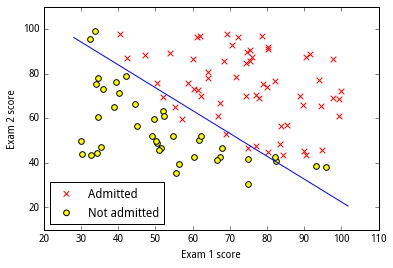

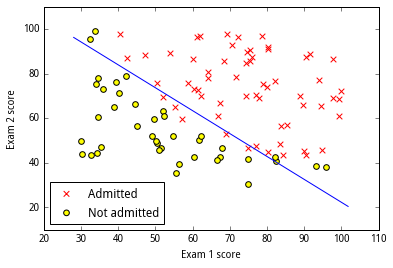

In [26]:
%matplotlib inline
def plotDecisionBoundary(theta, X, Y): # 画出决策边界
    # 先画出数据点
    fig = plt.figure()
    pos = plt.scatter(X[Y == 1, 1], X[Y == 1, 2], s=32, c='red', marker='x')
    neg = plt.scatter(X[Y == 0, 1], X[Y == 0, 2], s=32, c='yellow', marker='o')
    plt.xlabel('Exam 1 score')
    plt.ylabel('Exam 2 score')
    plt.legend((pos, neg), ('Admitted', 'Not admitted'), scatterpoints=1, loc='lower left', ncol=1, fontsize=12) # 这样给scatter添加lagend
    # 画决策边界
    plot_x = [X[:, 1].min() - 2, X[:, 1].max() + 2]
    plot_y = -(theta[1] * plot_x + theta[0]) / theta[2]
    plt.plot(plot_x, plot_y)
    
plotDecisionBoundary(np.array([[-24.932998460539014],[0.204407718945030],[0.199618080892081]]), X, Y) # 这是matlab使用fminunc优化的结果
plotDecisionBoundary(theta.get_value(), X, Y) # 我的结果

### Plot the convergence graph<span id='convergenceGraph'></span>

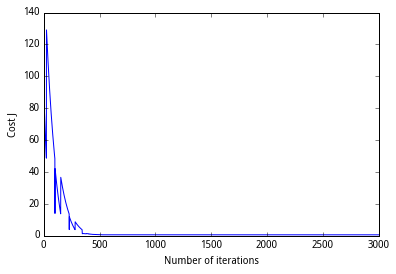

In [31]:
fig = plt.figure() 
plt.plot(np.arange(max_iters) + 1, J_history)
plt.xlim(0, 3000)
plt.xlabel('Number of iterations')
plt.ylabel('Cost J')

### 使用sklearn训练LogisticRegression模型

In [32]:
from sklearn.linear_model import LogisticRegression  
lr = LogisticRegression(solver='newton-cg') # 或者使用liblinear...
lr.fit(X,Y) # 训练
print (lr.predict(X) == Y).sum()/100.0 # 计算准确率
print lr.coef_ # 系数?

0.89
[[  4.70324044e-17   2.05353741e-01   2.00582821e-01]]


### 逻辑回归损失函数的推导<span id='logisticLoss'></span>

由于sigmoid函数的定义域是$ ( -\infty , + \infty ) $,而值域为$ ( 0 , 1 ) $，可以看做是概率的表示，我们将sigmoid函数看成样本数据的概率密度函数，每一个样本点，都可以通过sigmoid函数计算出其概率密度。   
考虑$x$具有p个独立变量的向量$ x^T = ( x_1 , x_2 , \cdots , x_p ) $，设条件概率$ P ( Y=1 \mid x ; \theta ) = p $为给定$x$，$Y = 1$的概率。逻辑回归模型可表示为:
$$ 
\begin{align} 
	& h_{ \theta } (x) = \frac {1} { 1 + e^{ - \theta^Tx } }  \notag \\
	& P ( Y = 1 \mid x ; \theta ) = h_{ \theta } (x) \notag \\
	& P ( Y = 0 \mid x; \theta) = 1 - h_{ \theta } (x)  \notag
\end{align}
$$   
假设有n个观测样本，观测值分别为$ y_1 , y_2 , \cdots , y_n $，设$ p_i = P ( y^{ (i) } = 1 \mid x^{ (i) } : \theta ) $为给定条件下得到$ y_i = 1 $的概率，在同样条件下得到$ y_i = 0 $的条件概率为$ P( y^{ (i) } = 0 \mid x^{ (i) } : \theta ) = 1 - p_i $。于是，得到一个观测值的概率为：
$$ 
\begin{align} 
	P(y_i) &= p_i^{ y^{ (i) } } ( 1 - p_i )^{ 1 - y^{ (i) } } \notag \\
		     &= \left ( h_{\theta} (x^{ (i) }) \right )^{ y^{ (i) } } \left( 1 - h_{\theta} (x^{ (i) }) \right )^{1- y^{ (i) } }  \notag
\end{align}
$$   
因为各项观测独立，所以它们的联合分布可以表示为各边际分布的乘积：
$$ 
\begin{align} 
	L ( \theta ) &= p( \vec y \mid X ; \theta ) \notag \\
					  &= \prod_{i=1}^n p \left ( y^{(i)} \mid x^{(i)} ; \theta \right ) \notag \\
					  &= \prod_{i=1}^n \left ( h_{\theta} (x^{(i)}) \right )^{ y^{(i)} } \left( 1 - h_{\theta} (x^{(i)}) \right )^{1- y^{(i)} }  \notag
\end{align}
$$   
上式称为n个观测的似然函数。我们的目标是能够求出使这一似然函数的值最大的参数估计。于是，最大似然估计的关键就是求出参数$\theta$，使上式取得最大值。   
对上述函数求对数：   
$$ 
\begin{align} 
	\ell ( \theta ) &= \log L( \theta ) \notag \\
	                      &= \sum_{ i = 1 }^n y^{(i)} \log h( x^{(i)} ) + ( 1 - y^{(i)}) \log ( 1 - h ( x^{(i)} ) ) \notag
\end{align}
$$    
取负之后，恰恰就是最小化cross entropy！

